# Background

This notebook demonstrates a single model which combines paid and reported losses that converge to the same ultimate.

In [1]:
import torch as pt
import pyro.distributions as dist
import pyro
from pyro.infer.reparam import SplitReparam
from matplotlib import pyplot as plt

# Definitions

The base line model is defined using the per development age means and standard deviations of the loss development factors. Note that the first values is an actual loss value, and not a loss development.

In [2]:
paid_loss_development_factor_mean = pt.Tensor([0.3, 3.0, 1.8, 1.2, 1.1])
paid_loss_development_factor_std  = pt.Tensor([2.0, 2.0, 1.0, 0.2, 0.1])
reported_loss_development_factor_mean = pt.Tensor([0.6, 1.3, 1.2, 1.1, 1.03])
reported_loss_development_factor_std  = pt.Tensor([0.1, 0.2, 0.1, 0.05, 0.02])

We now figure out the parameters of the log-normal distribution of the loss development factors.

In [3]:
def log_normal_z_params(mu, sigma):
    return pt.log(mu * mu / pt.sqrt(mu * mu + sigma * sigma)), \
           pt.sqrt(pt.log(1 + sigma * sigma / mu * mu))

paid_loss_development_factor_mu, paid_loss_development_factor_sigma = \
    log_normal_z_params(paid_loss_development_factor_mean,paid_loss_development_factor_std)
reported_loss_development_factor_mu, reported_loss_development_factor_sigma = \
    log_normal_z_params(reported_loss_development_factor_mean, reported_loss_development_factor_std)

Below is a definition of the transformation which converts loss development factors into the cumulative loss.

In [4]:
class CumSumTransform(dist.transforms.Transform):
    domain = dist.constraints.independent(dist.constraints.real, 1)
    codomain = dist.constraints.independent(dist.constraints.real, 1)
    bijective = True

    def log_abs_det_jacobian(self, x, y):
        return x.new_zeros(x.shape[:(-1)])

    def _call(self, x):
        return x.cumsum(dim=-1)

    def _inverse(self, x):
        return pt.diff(x, prepend=x.new_zeros(x.shape[:-1] +(1,)))

Let's define our loss distributions.

In [5]:
# Loss development distributions
paid_loss_development_factor_dist = dist.Normal(paid_loss_development_factor_mu, paid_loss_development_factor_sigma)
reported_loss_development_factor_dist = dist.Normal(reported_loss_development_factor_mu, reported_loss_development_factor_sigma)

# Cumulative loss distributions
paid_loss_dist = dist.TransformedDistribution(paid_loss_development_factor_dist,
                                                  [CumSumTransform(), dist.transforms.ExpTransform()])
reported_loss_dist = dist.TransformedDistribution(reported_loss_development_factor_dist,
                                                  [CumSumTransform(), dist.transforms.ExpTransform()])

# Baseline model

In [6]:
def base_model():
    paid_loss = pyro.sample("paid_loss", paid_loss_dist)
    reported_loss = pyro.sample("reported_loss", reported_loss_dist)
    return paid_loss, reported_loss

We use Stochastic Variational Inference (SVI) to approximate the base line models distribution. SVI is not needed for the base line model but we will use later on for the same ultimate model.

In [7]:
def fit(model, num_steps=501, lr=0.1):
    pyro.clear_param_store()
    guide = pyro.infer.autoguide.AutoMultivariateNormal(model)
    # Setup ELBO and optimizer
    elbo = pyro.infer.Trace_ELBO(vectorize_particles=True, num_particles=100)
    elbo.loss(model, guide)
    optim = pyro.optim.Adam({"lr": lr})
    svi = pyro.infer.SVI(model, guide, optim, loss=elbo)

    # optimize
    for i in range(num_steps):
        loss = svi.step()
        if i % 100 == 0:
            print(f"step {i} loss = {loss:0.6g}")

    return guide

base_guide = fit(base_model)


INFO 	 Guessed max_plate_nesting = 1


step 0 loss = 55.1195
step 100 loss = 1.91426
step 200 loss = 1.33835
step 300 loss = 1.20583
step 400 loss = 1.06528
step 500 loss = 0.63092


Let's sample and plot the baseline model.

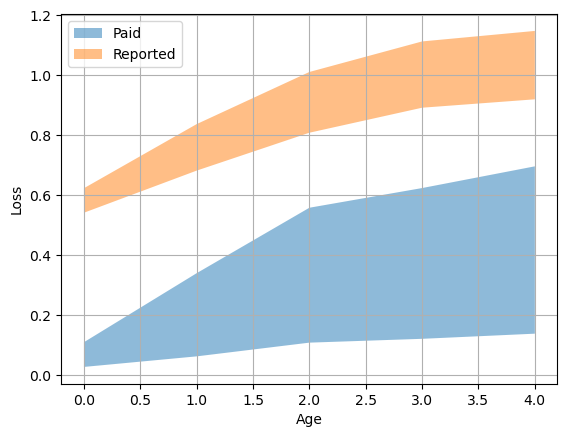

In [8]:
base_samples = pyro.infer.WeighedPredictive(base_model, guide=base_guide, num_samples=10000,
                                            parallel=True, return_sites=["paid_loss", "reported_loss"])()

lower_percentile = 0.25
upper_percentile = 0.75

def plot_ci(samples, **kwargs):
    lower, upper = pyro.ops.stats.quantile(samples, [lower_percentile, upper_percentile])
    plt.fill_between(range(samples.shape[-1]), lower, upper, **kwargs)

plot_ci(base_samples.samples["paid_loss"], alpha=0.5, label="Paid")
plot_ci(base_samples.samples["reported_loss"], alpha=0.5, label="Reported")
plt.legend(loc="upper left")
plt.xlabel("Age")
plt.ylabel("Loss")
plt.grid()

We can observe that the last age paid and reported losses are not the same, as they have different distributions.

# Same ultimate model

The same ultimate model is derived from the baseline model by conditioning it, requiring that the last age paid and reported losses are the same.

In [9]:
# Split last loss
split_reparam = SplitReparam([len(paid_loss_development_factor_mu) - 1, 1], -1)
split_model = pyro.poutine.reparam(base_model, dict(paid_loss=split_reparam, reported_loss=split_reparam))
# Equalize last loss
same_utimate_model = pyro.poutine.equalize(split_model, ["paid_loss_split_1", "reported_loss_split_1"])
same_ultimate_guide = fit(same_utimate_model)

INFO 	 Guessed max_plate_nesting = 1


step 0 loss = 57.6525
step 100 loss = 3.07419
step 200 loss = 2.64964
step 300 loss = 2.34981
step 400 loss = 2.15189
step 500 loss = 2.20693


Let's sample the same ultimate model and plot the loss distributions.

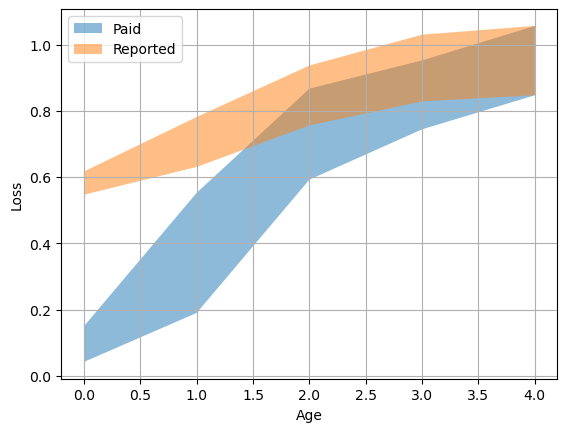

In [10]:
same_ultimate_samples = pyro.infer.WeighedPredictive(same_utimate_model, guide=same_ultimate_guide, num_samples=10000,
                                                     parallel=True, return_sites=["paid_loss", "reported_loss"])()

plot_ci(same_ultimate_samples.samples["paid_loss"], alpha=0.5, label="Paid")
plot_ci(same_ultimate_samples.samples["reported_loss"], alpha=0.5, label="Reported")
plt.legend(loc="upper left")
plt.xlabel("Age")
plt.ylabel("Loss")
plt.grid()

We can see how the conditioning of the model changed the loss distributions. Now the last age paid and reported losses have the same distribution, and they are in fact identical (you can look at the samples in order to verify this).

We can now look at all four distributions in order to get a sense of the conditioning changed our original distribution.

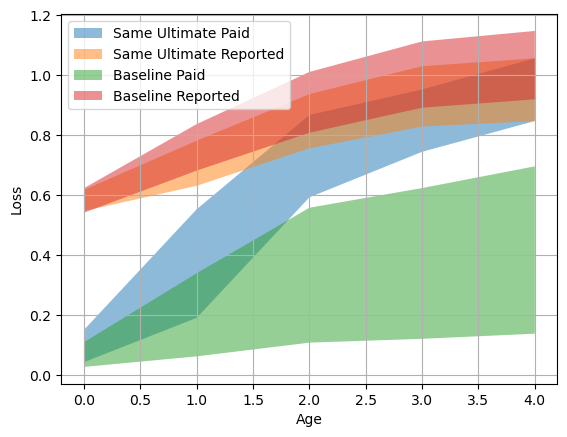

In [11]:
plot_ci(same_ultimate_samples.samples["paid_loss"], alpha=0.5, label="Same Ultimate Paid")
plot_ci(same_ultimate_samples.samples["reported_loss"], alpha=0.5, label="Same Ultimate Reported")
plot_ci(base_samples.samples["paid_loss"], alpha=0.5, label="Baseline Paid")
plot_ci(base_samples.samples["reported_loss"], alpha=0.5, label="Baseline Reported")
plt.legend(loc="upper left")
plt.xlabel("Age")
plt.ylabel("Loss")
plt.grid()

Note how the confidence interval of the same ultimate model paid losses starts becoming narrower as the age increases from the second age onwards.